In [2]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp

import candas as can
import gumbi as gmb
from candas.test import FluorescenceData, QuantStudio

import pathlib as pl
code_pth = pl.Path.cwd()  # for running in Jupyter
# code_pth = pl.Path(__file__)  # for running in terminal
fig_pth = code_pth.parent
data_pth = fig_pth / 'data'
graph_pth = fig_pth / 'graphics'
graph_pth.mkdir(exist_ok=True)

gen_pth = fig_pth / 'generated'
gen_pth.mkdir(exist_ok=True)

plt.style.use(str(can.style.futura))

%config InlineBackend.figure_format = 'retina'

In [3]:
fig_num = 'ED1'

panel = None
subpanel = None

def savefig(fig=None, title=None):
    fig = fig or plt.gcf()
    title = title or 'Fig_'+'_'.join([str(el) for el in [fig_num, panel, subpanel] if el is not None])
    print(f'Saving {title} in {graph_pth}:', end='')
    for ext in ['svg', 'png']:
        try:
            fig.savefig(graph_pth / f'{title}.{ext}', dpi=600, transparent=True)
            print(f' [.{ext}]', end='')
        except AttributeError:
            print(f' [.{ext} failed]', end='')
    print(' done')

# JG075A: EGFR Blocker Stoichiometry

In [4]:
cmax = 40

JG075A = (
    QuantStudio(data_pth / 'JG075A EGFR Blocker Stoichiometry.xlsx', 'JG075A')
    .import_data()
    .format_reactions()
    .index_reactions()
    .subtract_background()
    .normalize_reactions(cmax=cmax)
    .trim_reactions()
#     .invert_fluorophore('HEX')
)
JG075A.reactions.wide = JG075A.reactions.wide.drop(columns=['Stage', 'Derivative'])
JG075A.reactions.signal_columns = [col for col in JG075A.reactions.signal_columns if col != 'Derivative']

# # Denote reaction conditions
JG075A.reactions.wide = (
    JG075A.reactions.wide
    .merge(pd.read_csv(data_pth / 'JG075A Plate Map.csv'))#[['Sample','WT Conc','Competitor Conc','Primer Conc']])
    .assign(lg10_Blocker = lambda df: np.log10(df['Blocker μM']))
    .replace({'lg10_Blocker': {-np.inf: -2}})
#     .drop(columns=['CT'])
    .query('Well != 73')  # Outlier, weird drift in baseline
)

JG075A.reactions.neaten()

/home/john/projects/CAN_paper/env/can_manuscript/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


,Experiment,Well,Target,lg10_Copies,Outlier,WellPosition,Copies,Reporter,Sample,Task,Comments,CT,Reaction,Blocker,Blocker μM,WellName,lg10_Blocker,Cycle,Fluorescence,Corr_Fluorescence
0,JG075A,1,S075_WT,8.0,False,A1,100000000.0,EVAGREEN,JG075A_001,STANDARD,,56.821556,0,MMMMx,3.162278,A1,0.5,3,-0.006387,0.089428
1,JG075A,1,S075_WT,8.0,False,A1,100000000.0,EVAGREEN,JG075A_001,STANDARD,,56.821556,0,MMMMx,3.162278,A1,0.5,4,-0.005734,0.045397
2,JG075A,1,S075_WT,8.0,False,A1,100000000.0,EVAGREEN,JG075A_001,STANDARD,,56.821556,0,MMMMx,3.162278,A1,0.5,5,-0.004740,0.002104
3,JG075A,1,S075_WT,8.0,False,A1,100000000.0,EVAGREEN,JG075A_001,STANDARD,,56.821556,0,MMMMx,3.162278,A1,0.5,6,-0.001089,-0.035434
4,JG075A,1,S075_WT,8.0,False,A1,100000000.0,EVAGREEN,JG075A_001,STANDARD,,56.821556,0,MMMMx,3.162278,A1,0.5,7,0.000279,-0.077918
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12235,JG075A,375,S075_SNV,1.0,False,P15,10.0,EVAGREEN,JG075A_375,STANDARD,,20.933987,238,None,0.000000,P15,-2.0,46,0.945859,1.537327
12236,JG075A,375,S075_SNV,1.0,False,P15,10.0,EVAGREEN,JG075A_375,STANDARD,,20.933987,238,None,0.000000,P15,-2.0,47,0.945898,1.524482
12237,JG075A,375,S075_SNV,1.0,False,P15,10.0,EVAGREEN,JG075A_375,STANDARD,,20.933987,238,None,0.000000,P15,-2.0,48,0.949281,1.518882
12238,JG075A,375,S075_SNV,1.0,False,P15,10.0,EVAGREEN,JG075A_375,STANDARD,,20.933987,238,None,0.000000,P15,-2.0,49,0.952237,1.512355


In [52]:
target_palette = list(zip(['S075_WT','S075_SNV'],['Purples','Greens']))
blockers = ['L-MMMMx','MMMMx']

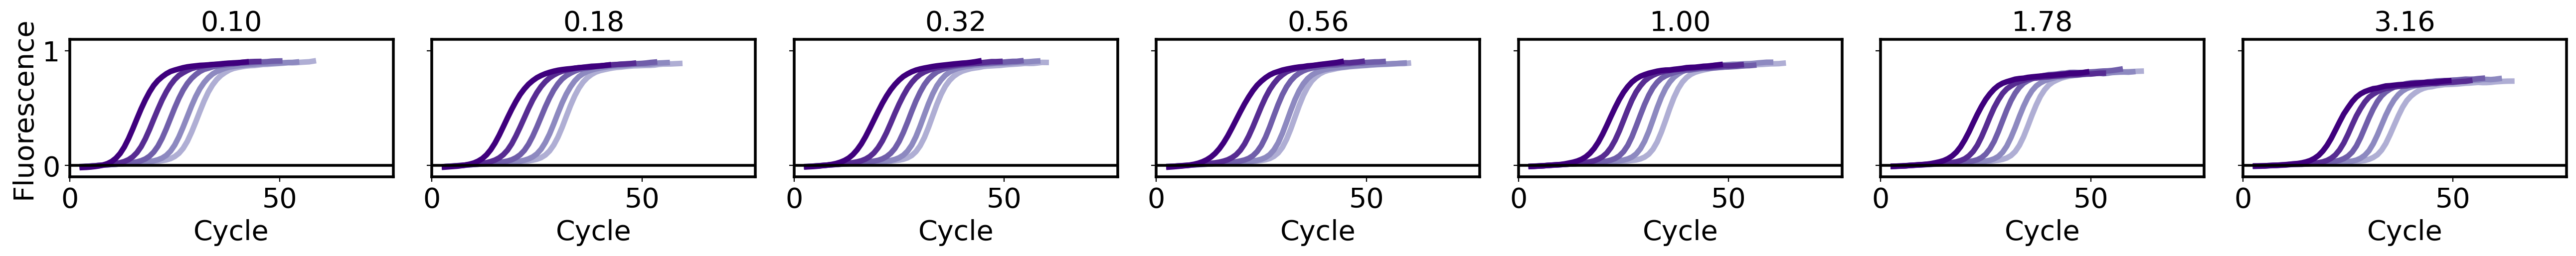

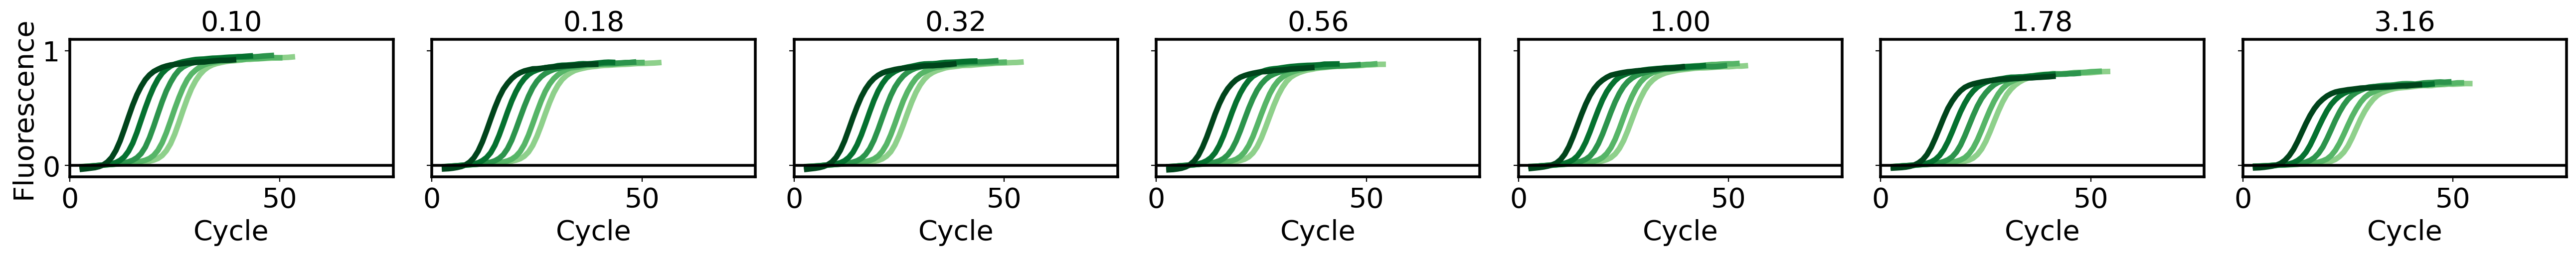

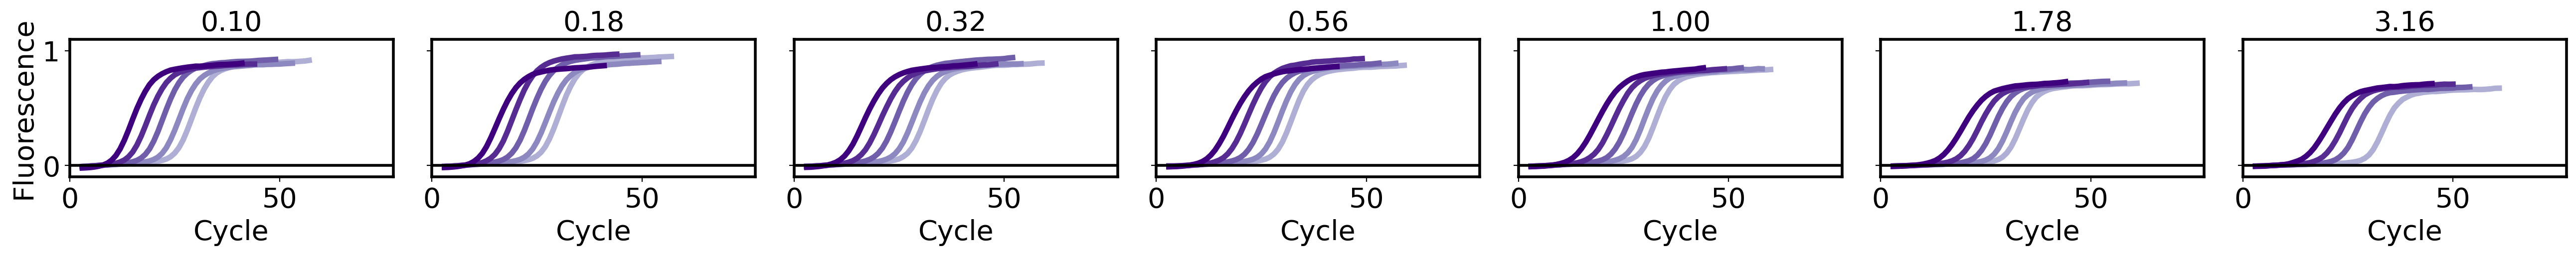

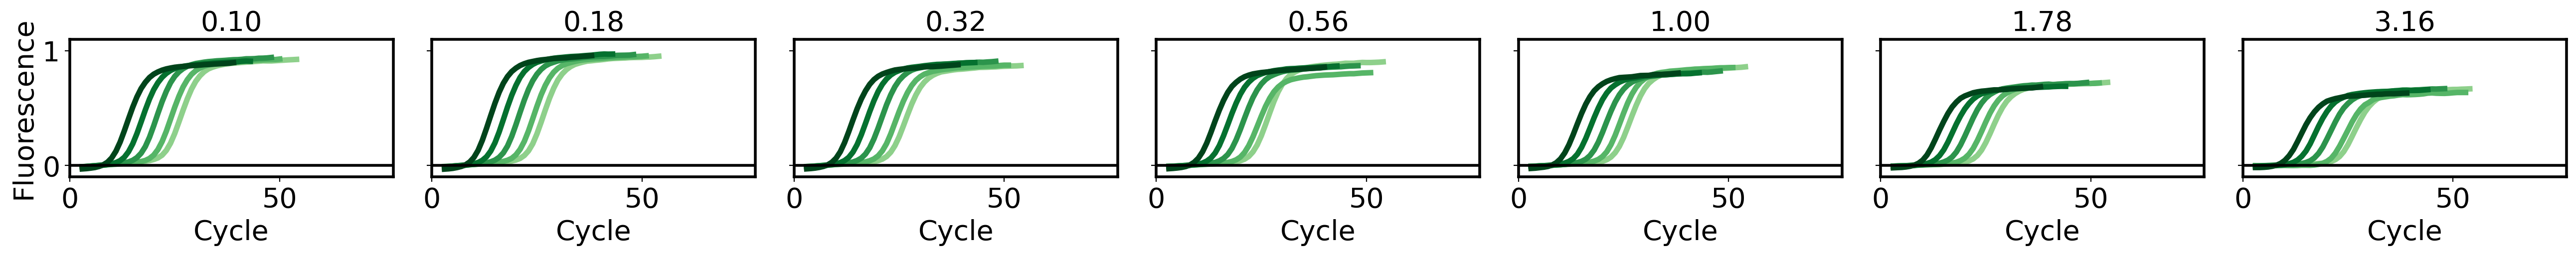

In [53]:
hue = 'lg10_Copies'
extent = np.max(np.abs(JG075A.reactions.wide[hue]))
norm = mpl.colors.Normalize(vmin=JG075A.reactions.wide[hue].min(), vmax=JG075A.reactions.wide[hue].max())


for blocker in blockers:
    for target, palette in target_palette:
        data = JG075A.reactions.data
        data = data[
    #         (data.Cycle<=cmax) &
            (data.lg10_Copies>=4) &
            (data.Target==target) &
            (data.Blocker==blocker)
        ]

        g = sns.relplot(data = data,
                        x='Cycle', y='Fluorescence', col='Blocker μM', units='Reaction', hue = hue,
                        legend = False, palette=palette, hue_norm=norm, kind='line', estimator=None,
                        height=3, aspect=1.25, linewidth=4,
                        facet_kws={
                            'margin_titles': True,
                            'despine': False})

        g.refline(y=0, color='k', linestyle='-')
        g.set_titles(col_template="{col_name:.2f}", row_template="{row_name}")
        g.set(ylim=[-0.1, 1.1], xlim=[0, JG075A.reactions.data.Cycle.max()])
        # g.set_titles(col_template="", row_template="")
        plt.tight_layout();

        # can.utils.savefig('JG075A GBP6 Tripartite Curves')

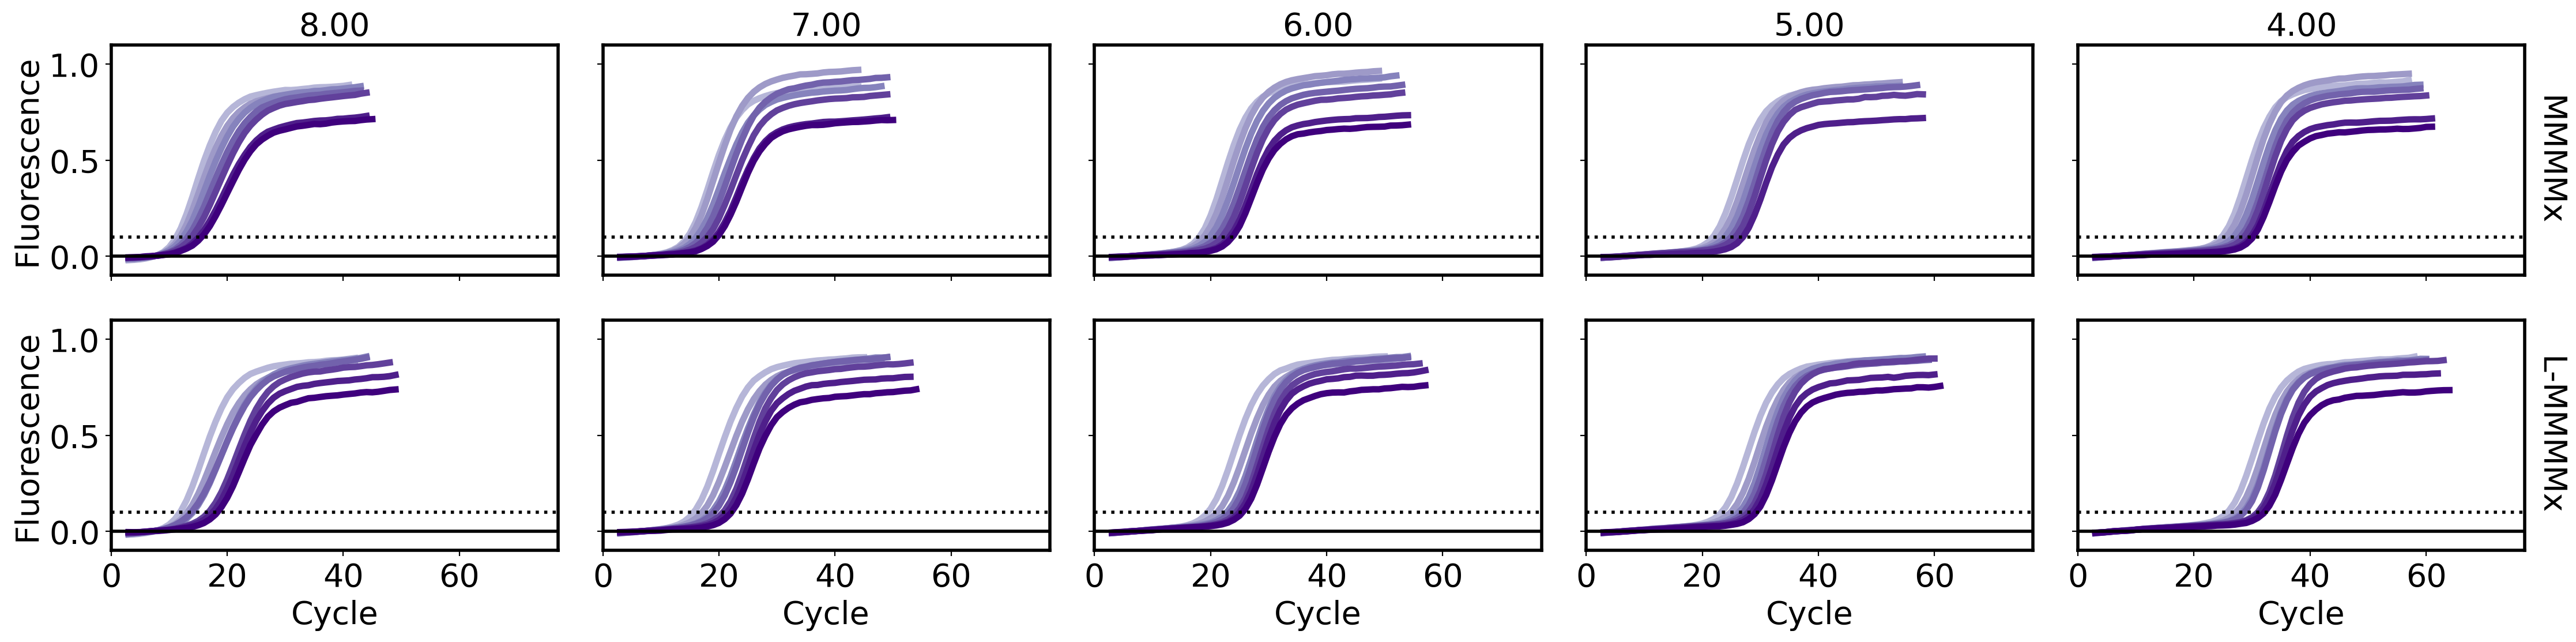

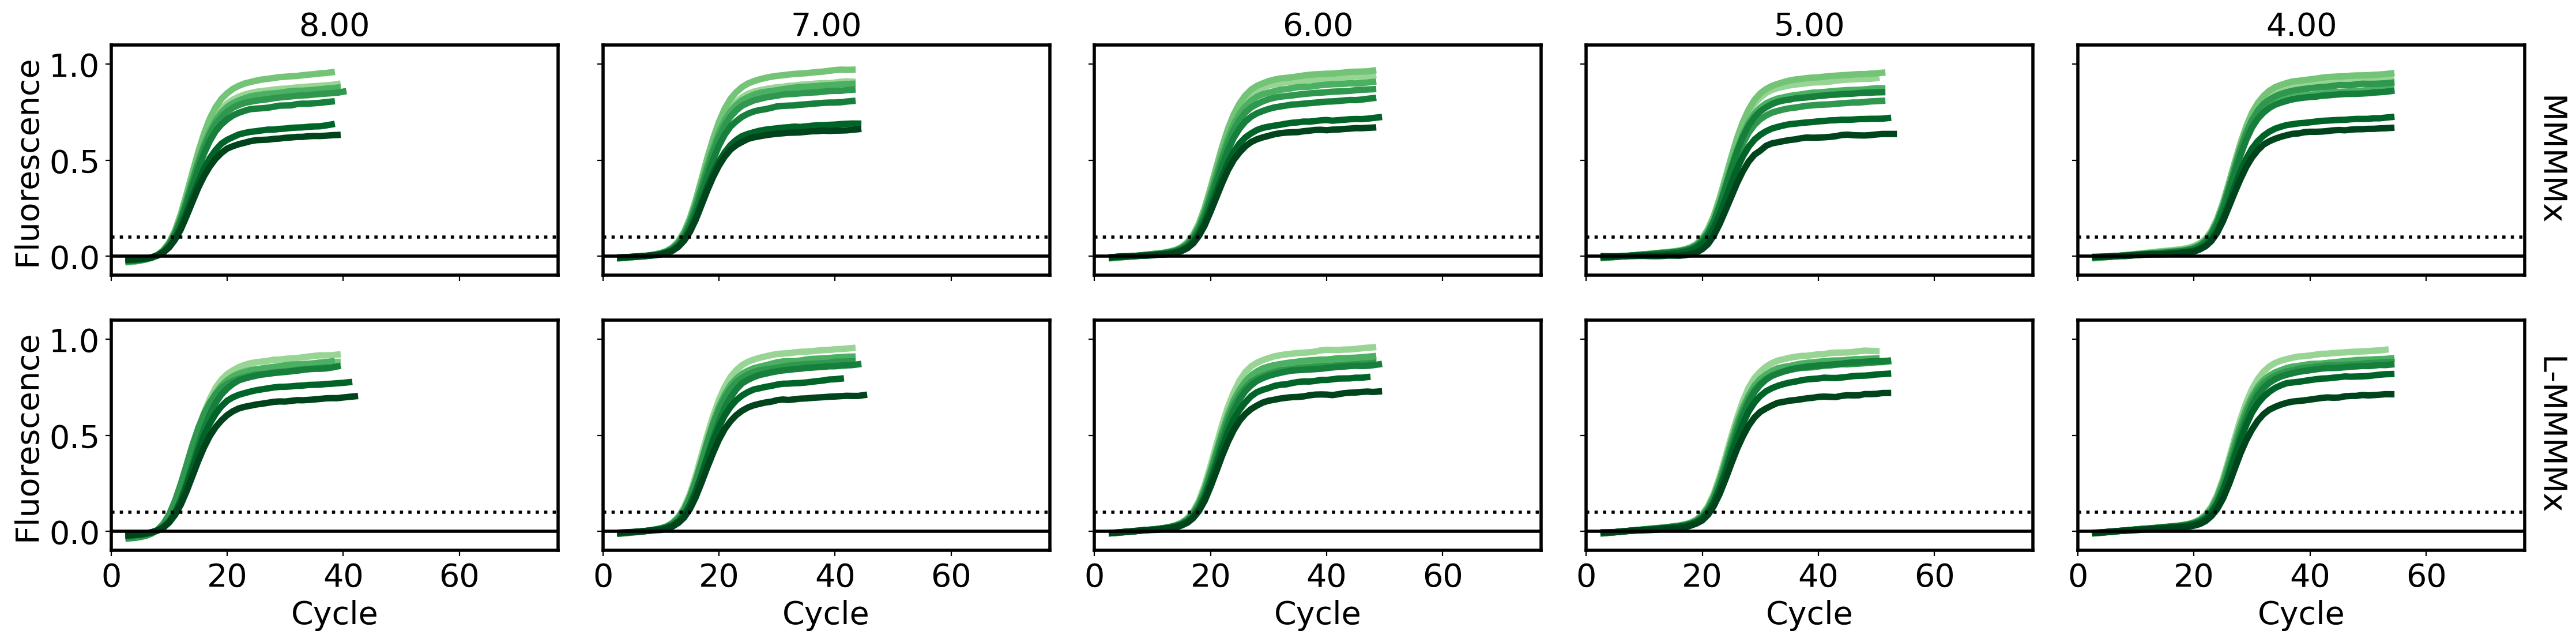

In [54]:
hue = 'lg10_Blocker'
extent = np.max(np.abs(JG075A.reactions.wide[hue]))
norm = mpl.colors.Normalize(vmin=JG075A.reactions.wide[hue].min(), vmax=JG075A.reactions.wide[hue].max())


for target, palette in target_palette:
    data = JG075A.reactions.data
    data = data[
        (data.lg10_Copies>=4) &
        (data.Blocker!="None") &
        (data.Target==target) &
        (data.Well!=73)
    ]

    g = sns.relplot(data = data,
                    x='Cycle', y='Fluorescence', col='lg10_Copies', row='Blocker', units='Reaction', hue = hue,
                    legend = False, palette=palette, hue_norm=norm, kind='line', estimator=None, 
                    height=3, aspect=1.5, linewidth=4,
                    col_order = [8.0,7.0,6.0,5.0,4.0],
                    facet_kws={
                        'margin_titles': True,
                        'despine': False})

    g.refline(y=0, color='k', linestyle='-')
    g.refline(y=0.1, color='k', linestyle=':')
    g.set_titles(col_template="{col_name:.2f}", row_template="{row_name}")
    g.set(ylim=[-0.1, 1.1], xlim=[0, JG075A.reactions.data.Cycle.max()])
    # g.set_titles(col_template="", row_template="")
    plt.tight_layout();

    panel = 'B'
    subpanel = {'S075_WT': 'ii', 'S075_SNV': 'i'}[target]

In [55]:
smoothing = 0.01
threshold = 0.1

def get_CT(group, method='threshold'):
    """Interpolate and find second derivative max"""
    c = group.Cycle
    sig = group.Fluorescence
    c_ = np.linspace(c.min(), c.max(), 10000)
    spline = sp.interpolate.UnivariateSpline(c, sig, s=smoothing, k=4)
        
    threshold = 0.1
    crossing = -np.abs(threshold-spline(c_))
    CT = c_[np.argmax(crossing)]
    
    return CT

JG075A.reactions.data.drop(columns=['CT'], inplace=True)
data = JG075A.reactions.data
groupby = JG075A.reactions.metadata_columns
reaction_grps = data.groupby(groupby)
CTs = reaction_grps.apply(get_CT).rename('CT').reset_index()

JG075A.reactions.wide = JG075A.reactions.wide.merge(CTs[['Well','CT']])
JG075A.reactions.wide['CT']

basal_CTs = JG075A.reactions.wide.query('Blocker == "None"').set_index(['Target', 'lg10_Copies'])['CT']
ΔCTs = (JG075A.reactions.wide.set_index(['Target','lg10_Copies','Well'])['CT']-basal_CTs).rename('ΔCT').reset_index()
JG075A.reactions.wide = JG075A.reactions.wide.merge(ΔCTs)

In [56]:
import numpy as np 
import matplotlib.pyplot as plt

def multicolor_ylabel(fig, list_of_strings, list_of_colors, axis='x', anchorpad=0,
                      ybbox=(0, 0.2), xbbox=(0.2, -0.09), **kw):
    """this function creates axes labels with multiple colors
    ax specifies the axes object where the labels should be drawn
    list_of_strings is a list of all of the text items
    list_if_colors is a corresponding list of colors for the strings
    axis='x', 'y', or 'both' and specifies which label(s) should be drawn"""
    from matplotlib.offsetbox import AnchoredOffsetbox, TextArea, HPacker, VPacker

    # x-axis label
    if axis=='x' or axis=='both':
        boxes = [TextArea(text, textprops=dict(color=color, ha='left',va='bottom',**kw)) 
                    for text,color in zip(list_of_strings,list_of_colors) ]
        xbox = HPacker(children=boxes, align="center",pad=0, sep=5)
        anchored_xbox = AnchoredOffsetbox(loc=3, child=xbox, pad=anchorpad, frameon=False, bbox_to_anchor=xbbox,
                                          bbox_transform=fig.transFigure, 
                                          borderpad=0.)
        fig.add_artist(anchored_xbox)

    # y-axis label
    if axis=='y' or axis=='both':
        boxes = [TextArea(text, textprops=dict(color=color, ha='left',va='bottom',rotation=90,**kw)) 
                     for text,color in zip(list_of_strings[::-1], list_of_colors[::-1]) ]
        ybox = VPacker(children=boxes, align="center", pad=0, sep=5)
        anchored_ybox = AnchoredOffsetbox(loc=3, child=ybox, pad=anchorpad, frameon=False, bbox_to_anchor=ybbox, 
                                          bbox_transform=fig.transFigure, 
                                          borderpad=0.)
        fig.add_artist(anchored_ybox)

In [57]:
data = JG075A.reactions.wide
data = data[
    (data.lg10_Copies>=4) & 
    (data.Blocker!='None')
]

ds = gmb.DataSet(data, outputs=['ΔCT'])
gp = gmb.GP(ds).fit(continuous_dims = ['lg10_Copies', 'lg10_Blocker'],
                    categorical_dims=['Blocker', 'Target'])

Saving Fig_ED1_B_iii in /home/john/projects/CAN_paper/fig_ed1/graphics: [.svg] [.png] done


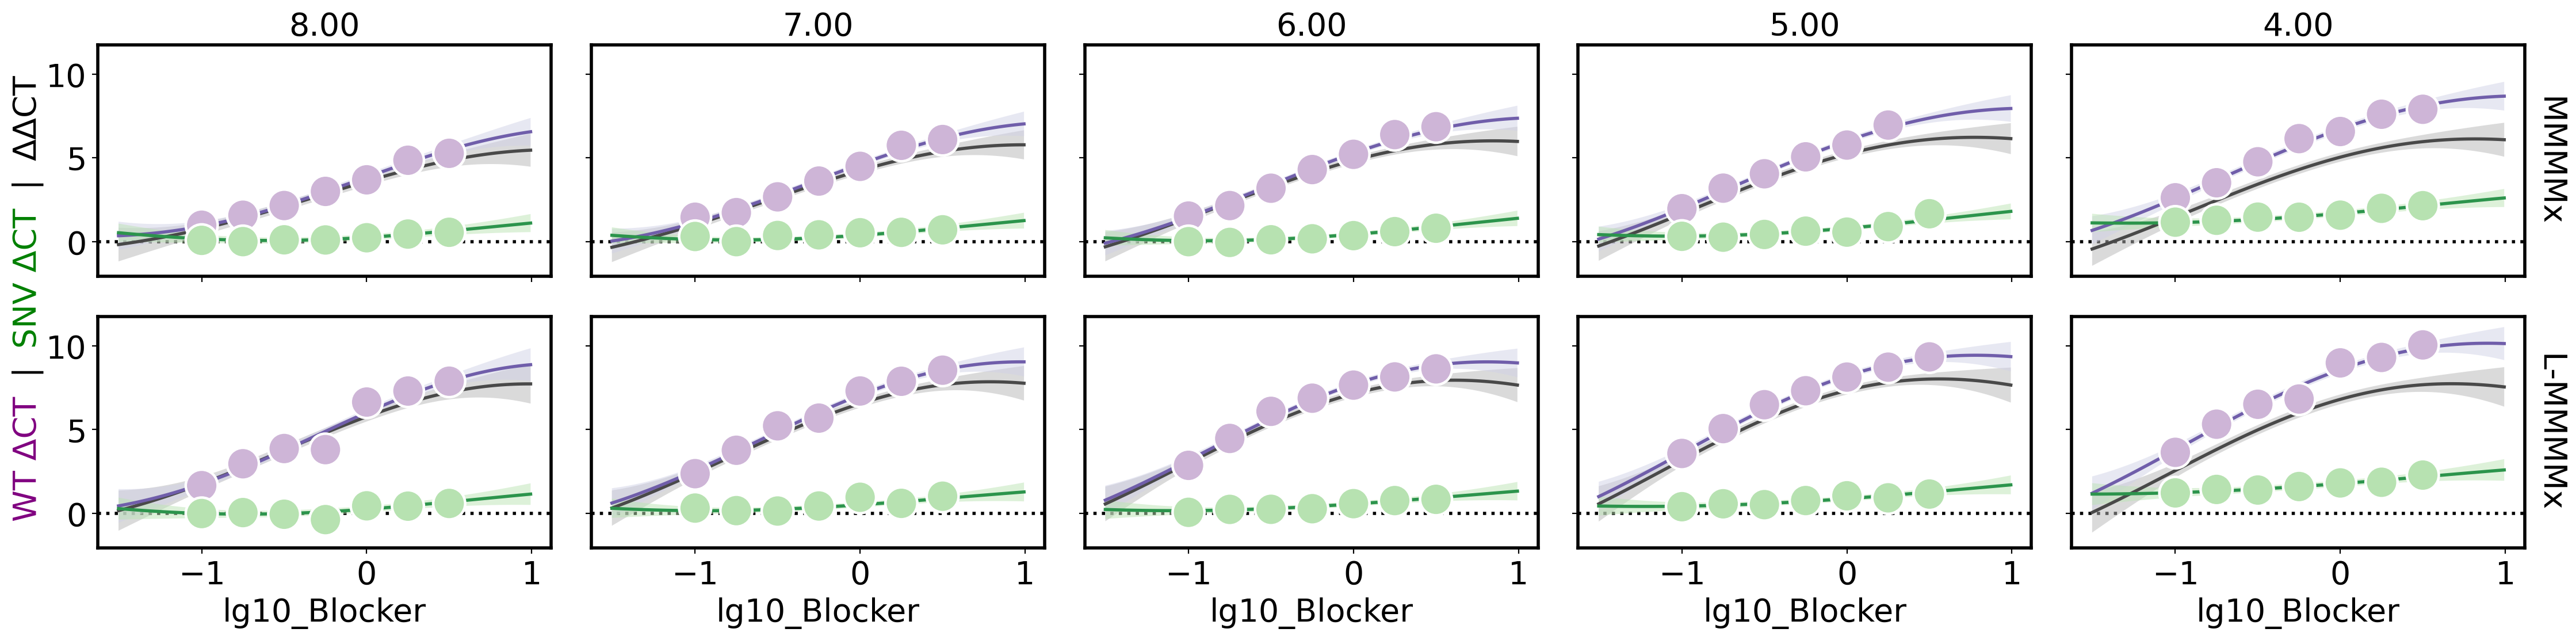

In [58]:
g = sns.relplot(data = data,
                x='lg10_Blocker', y='ΔCT', col='lg10_Copies', row='Blocker',
                hue = 'Target', col_order = [8.0,7.0,6.0,5.0,4.0],
                legend = False, palette='PRGn',
                kind='scatter', height=3, aspect=1.5, s=20**2,
                facet_kws={
                    'margin_titles': True,
                    'despine': False})

g.refline(y=0, color='k', linestyle=':', zorder=-11)
g.set_titles(col_template="{col_name:.2f}", row_template="{row_name}")

for (row_val, col_val), ax in g.axes_dict.items():
        
    at = gp.parray(lg10_Copies=col_val)
    X = gp.prepare_grid(at=at)['lg10_Blocker']
    ΔCT_WT = gp.predict_grid(categorical_levels={'Target': 'S075_WT', 'Blocker': row_val}, with_noise=False)
    ΔCT_SNV = gp.predict_grid(categorical_levels={'Target': 'S075_SNV', 'Blocker': row_val}, with_noise=False)
    ΔΔCT = ΔCT_WT-ΔCT_SNV
    ΔΔCT.name = 'ΔΔCT'

    plt.sca(ax)
    gmb.ParrayPlotter(x=X, y=ΔΔCT).plot(palette='binary')
    gmb.ParrayPlotter(x=X, y=ΔCT_WT).plot(palette='Purples')
    gmb.ParrayPlotter(x=X, y=ΔCT_SNV).plot(palette='Greens')
    
g.set(ylabel='')
    
fig = plt.gcf()
multicolor_ylabel(fig,('WT ΔCT',' | ','SNV ΔCT',' | ','ΔΔCT'),('purple','k','green','k','k'), axis='y', ybbox=(0, 0.2))
    
plt.tight_layout();

panel = 'B'
subpanel = 'iii'
savefig()